In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd
from sklearn.metrics import accuracy_score
import time

In [9]:
zip_file_url = "https://download.pytorch.org/tutorial/data.zip"
import requests, zipfile, io
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [10]:
import unicodedata, string
all_letters = string.ascii_letters + " .,;\'"
alphabet= {ch:i for i,ch in enumerate(all_letters)}

In [11]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

In [12]:
name_data = {}
for path in z.namelist():
    if path.startswith("data/names/") and path.endswith(".txt"):
        lang = path.split("/")[-1][:-4]
        with z.open(path) as f:
            lines = f.read().decode("utf-8").strip().split("\n")
            name_data[lang] = [unicodeToAscii(l).lower() for l in lines]
        print(f"{lang}: {len(name_data[lang])} names")

Arabic: 2000 names
Chinese: 268 names
Czech: 519 names
Dutch: 297 names
English: 3668 names
French: 277 names
German: 724 names
Greek: 203 names
Irish: 232 names
Italian: 709 names
Japanese: 991 names
Korean: 94 names
Polish: 139 names
Portuguese: 74 names
Russian: 9408 names
Scottish: 100 names
Spanish: 298 names
Vietnamese: 73 names


In [13]:
class LanguageNameDataset(Dataset):
    def __init__(self, name_dict, vocab):
        self.label_names = list(name_dict.keys())
        self.data   = []
        self.labels = []
        self.vocab  = vocab
        for idx, lang in enumerate(self.label_names):
            for nm in name_dict[lang]:
                self.data.append(nm)
                self.labels.append(idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        name = self.data[i]
        lbl  = self.labels[i]
        vec  = torch.tensor([self.vocab[c] for c in name], dtype=torch.long)
        return vec, torch.tensor(lbl, dtype=torch.long)

In [14]:
dataset = LanguageNameDataset(name_data, alphabet)
train_ds, test_ds = torch.utils.data.random_split(dataset, (len(dataset)-300, 300))

In [15]:
def collate_fn(batch):
    inputs, labels = zip(*batch)
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    labels_tensor = torch.stack(labels)
    return inputs_padded, labels_tensor

In [16]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, collate_fn=collate_fn)

In [17]:
with torch.no_grad():
    sample_seq = torch.tensor([0,1,1,0,2], dtype=torch.long)
    emb_layer  = nn.Embedding(3,2)
    out_seq    = emb_layer(sample_seq)
    print(sample_seq.shape, out_seq.shape)

torch.Size([5]) torch.Size([5, 2])


In [18]:
class LastTimeStep(nn.Module):
    def __init__(self, rnn_layers=1, bidirectional=False):
        super().__init__()
        self.rnn_layers     = rnn_layers
        self.num_directions = 2 if bidirectional else 1

    def forward(self, rnn_output):
        h_t = rnn_output[1]
        if isinstance(h_t, tuple):
            h_t = h_t[0]
        B = h_t.size(1)
        h_last = h_t.view(self.rnn_layers, self.num_directions, B, -1)[-1]
        return h_last.permute(1,0,2).reshape(B,-1)

In [19]:
# Build the RNN model
D_embed = 64
hidden_nodes= 256
num_classes = len(dataset.label_names)

first_rnn = nn.Sequential(
    nn.Embedding(len(alphabet), D_embed),        # (B, T) → (B, T, D)
    nn.RNN(D_embed, hidden_nodes, batch_first=True),
    LastTimeStep(),
    nn.Linear(hidden_nodes, num_classes),
)

In [20]:
def moveTo(obj, device):
    if hasattr(obj, "to"):
        return obj.to(device)
    elif isinstance(obj, (list, tuple, set)):
        return type(obj)(moveTo(x, device) for x in obj)
    elif isinstance(obj, dict):
        return {moveTo(k, device): moveTo(v, device) for k,v in obj.items()}
    else:
        return obj

def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    running_loss, y_true, y_pred = [], [], []
    start = time.time()
    for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
        inputs, labels = moveTo(inputs, device), moveTo(labels, device)
        y_hat = model(inputs)
        loss  = loss_func(y_hat, labels)
        if model.training:
            loss.backward(); optimizer.step(); optimizer.zero_grad()
        running_loss.append(loss.item())
        if score_funcs:
            lbl_np = labels.detach().cpu().numpy()
            pred_np= y_hat.detach().cpu().numpy()
            y_true.extend(lbl_np.tolist())
            y_pred.extend(pred_np.tolist())
    end = time.time()

    results[prefix + " loss"].append(np.mean(running_loss))
    y_pred = np.asarray(y_pred)
    if y_pred.ndim==2 and y_pred.shape[1]>1:
        y_pred = np.argmax(y_pred, axis=1)
    for name, fn in score_funcs.items():
        try:
            results[prefix + " " + name].append(fn(y_true, y_pred))
        except:
            results[prefix + " " + name].append(float("nan"))
    return end-start

In [21]:
def train_simple_network(model, loss_func, train_loader, test_loader=None, score_funcs=None,
                         epochs=13, device="cpu", checkpoint_file=None, lr=0.001):
    to_track = ["epoch","total time","train loss"]
    if test_loader: to_track += ["test loss"]
    for sc in score_funcs:
        to_track += [f"train {sc}"]
        if test_loader: to_track += [f"test {sc}"]

    results = {k:[] for k in to_track}
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    model.to(device)

    total_time = 0
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model.train()
        total_time += run_epoch(model, optimizer, train_loader, loss_func, device,
                                results, score_funcs, prefix="train", desc="Training")
        results["total time"].append(total_time)
        results["epoch"].append(epoch)
        if test_loader:
            model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device,
                          results, score_funcs, prefix="test", desc="Testing")
    if checkpoint_file:
        torch.save({'model':model.state_dict(), 'results':results}, checkpoint_file)
    return pd.DataFrame.from_dict(results)

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_func = nn.CrossEntropyLoss()

batch_train = train_simple_network(
    first_rnn,
    loss_func,
    train_loader,
    test_loader=test_loader,
    score_funcs={'Accuracy': accuracy_score},
    device=device,
    epochs=370
)

Epoch:   0%|          | 0/370 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/618 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

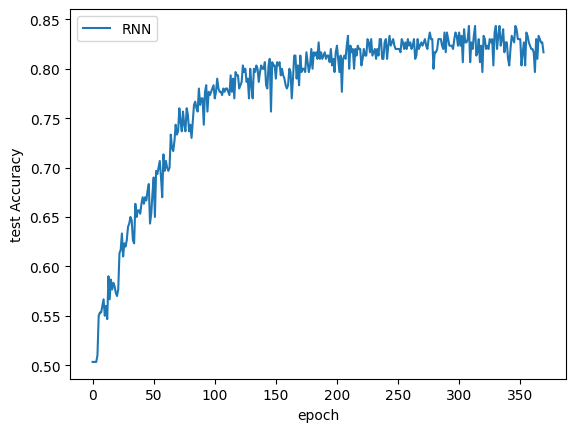

In [23]:
sns.lineplot(x='epoch', y='test Accuracy', data=batch_train, label='RNN')
plt.show()

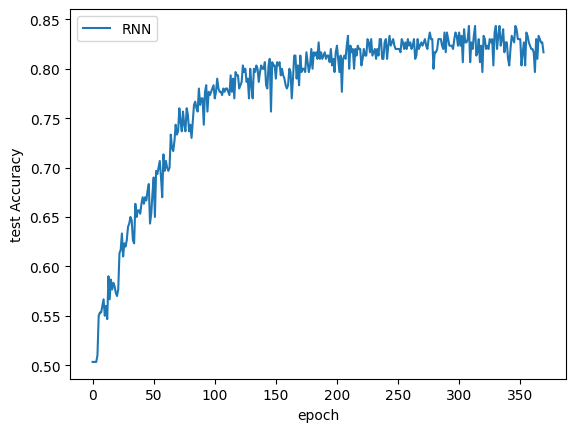

In [24]:
sns.lineplot(x='epoch', y='test Accuracy', data=batch_train, label='RNN')
plt.show()

In [26]:
import torch
import torch.nn as nn

# Sample data: 3 batches, each with 5 names
names_batch = [
    ["John", "Elizabeth", "Michael", "Jennifer", "Christopher"],  # American
    ["Hiroshi", "Yuki", "Takeshi", "Aiko", "Kenji"],              # Japanese
    ["Raj", "Priya", "Aditya", "Divya", "Vikram"]                 # Indian
]

# Step 1: Convert characters to indices
all_chars = set(ch for batch in names_batch for name in batch for ch in name)
char_to_idx = {char: i + 1 for i, char in enumerate(sorted(all_chars))}
char_to_idx['<PAD>'] = 0
idx_to_char = {i: char for char, i in char_to_idx.items()}

# Print vocabulary size and mapping example
print("Character vocabulary size:", len(char_to_idx))
print("Character mapping example:", {k: char_to_idx[k] for k in list(char_to_idx.keys())[:5]})

# Step 2: Find the longest name to determine max sequence length
max_len = max(len(name) for batch in names_batch for name in batch)
print("Maximum name length:", max_len)

# Step 3: Convert names to padded sequences of indices
input_data = torch.zeros(3, 5, max_len, dtype=torch.long)
for b, batch in enumerate(names_batch):
    for i, name in enumerate(batch):
        for j, ch in enumerate(name):
            input_data[b, i, j] = char_to_idx[ch]

print("Input tensor shape:", input_data.shape)
print("\nEncoded first name in batch 1:", input_data[0, 0])

# Decode back to string
decoded = ''.join(idx_to_char[idx.item()] for idx in input_data[0, 0] if idx.item() > 0)
print("Decoded back:", decoded)

# Step 4: RNN with Embedding
vocab_size = len(char_to_idx)
embed_dim = 10

class NameRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_size, batch_first=True)

    def forward(self, x):
        emb = self.embedding(x)  # [batch_size, seq_length, embed_dim]
        out, hidden = self.rnn(emb)
        return out, hidden

# Process the first name in each batch
model = NameRNN(vocab_size, embed_dim, hidden_size=20)
first_names = input_data[:, 0, :]  # [3, max_len]
output, hidden = model(first_names)

print("\nOutput shape for first names:", output.shape)  # [3, max_len, 20]
print("Hidden state shape:", hidden.shape)              # [1, 3, 20]

Character vocabulary size: 36
Character mapping example: {'A': 1, 'C': 2, 'D': 3, 'E': 4, 'H': 5}
Maximum name length: 11
Input tensor shape: torch.Size([3, 5, 11])

Encoded first name in batch 1: tensor([ 6, 27, 20, 26,  0,  0,  0,  0,  0,  0,  0])
Decoded back: John

Output shape for first names: torch.Size([3, 11, 20])
Hidden state shape: torch.Size([1, 3, 20])
